<a href="https://colab.research.google.com/github/ics-projects/ML-Lab2-Clone/blob/master/CAT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## (i) Datapreprocessing

### Dataset charachteristics
https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset

In [2]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
Y = cal_housing.target
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Missing Values
According to the dataset description, there are no missing values. We will move on to encoding

In [3]:
missing_value_cols = list(X.columns[X.isna().any()])
print(len(missing_value_cols))

0


### Encoding

There is no nominal data

In [4]:
categorical_features = X.select_dtypes(include=['object']).columns
categorical_features

Index([], dtype='object')

There also isn't any ordinal data

In [5]:
print(len(X.select_dtypes(include=['int64', 'float64']).columns)==len(X.columns))

True


All the data seems to be interval and ratio data, therefore we can move on to feature selection

### Feature Selection

Find out features that account for 90% of the variance

In [6]:
variance_threshold = 0.90
X_copy = StandardScaler().fit_transform(X)

pca = PCA()
principle_components = pca.fit_transform(X_copy)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)

no_of_variables = sum(x <= variance_threshold for x in cumulative_variance)
print("PCs needed: ", no_of_variables)

[0.25336868 0.48853113 0.64741747 0.77629718 0.90167913 0.98410164
 0.99430186 1.        ]
PCs needed:  4


In [7]:
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=4)
principle_components = pca.fit_transform(X)

principal_df = pd.DataFrame(data = principle_components, columns = ['component 1', 'component 2', 'component 3', 'component 4'])
final_data = pd.concat([principal_df, pd.DataFrame(Y, columns=['Target'])], axis=1)
print(final_data)

       component 1  component 2  component 3  component 4  Target
0         1.882704    -0.503362    -0.314134    -2.555093   4.526
1         1.371120    -0.121406     1.905258    -1.872984   3.585
2         2.086868    -0.501136    -0.937245    -2.100133   3.521
3         1.575801    -1.239495    -1.025957    -1.286721   3.413
4         1.591206    -1.345264    -1.249171    -0.450778   3.422
...            ...          ...          ...          ...     ...
20635     1.386779    -1.296137     0.054262     1.063026   0.781
20636     1.875219    -0.671533     0.155700     0.644612   0.771
20637     1.402357    -1.096426     0.567135     1.090397   0.923
20638     1.542943    -1.059408     0.365472     0.968799   0.847
20639     1.405516    -0.896727     0.896812     0.900237   0.894

[20640 rows x 5 columns]


## (ii) Pairplot

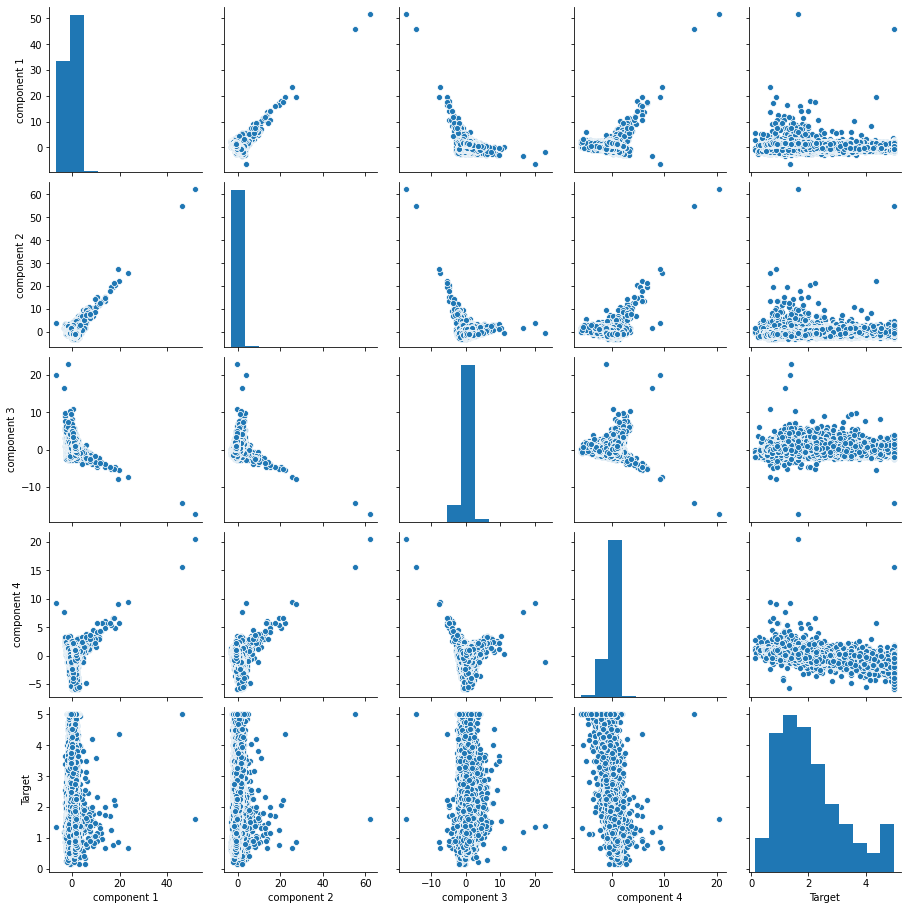

In [8]:
sns.pairplot(final_data)

From the pairplot we can see that most of the variables have a strong positve correlation.

# (iii) Model Selection

In this section, we would like to get the most effective regression model, based on accuracy.

To do this, we will first split the data into training and testing

**Data Splitting**

In [9]:
all_features = list(final_data.columns)
all_features
X_2 = final_data.loc[:,all_features[0]:all_features[-2]].values
y_2 = final_data.loc[:,[all_features[-1]]].values

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

Next, we will proceed to model selection by fitting various regression models to the data

In [10]:
result = {}
models = {'LinearRegression': linear_model.LinearRegression(),
          'Lasso': linear_model.Lasso(),
          'Ridge': linear_model.Ridge(),
          'ElasticNet': linear_model.ElasticNet()}

for i in models:
  models[i].fit(X_train, y_train)
  accuracy = models[i].score(X_test, y_test)
  result[i] = [accuracy]

pd.DataFrame(result)

,LinearRegression,Lasso,Ridge,ElasticNet
0,0.454431,-0.000004,0.454431,0.17762


# (iv) Hyperparameter Tuning

Below we will demonstrate hyperparameter tunining using Randomized Search

In [32]:
for i in models:
  regressor = models[i]
  if i == 'Lasso':
    random = RandomizedSearchCV(regressor,param_distributions=lasso_params,cv=3,n_jobs=-1)
    results = random.fit(X_train,y_train)
    print(results.best_score_)
    print("Best Params are ", results.best_params_)
    accuracy = results.score(X_test,y_test)
  result[i]=[accuracy]
pd.DataFrame(result)

0.45078855863631667
Best Params are  {'tol': 0.001, 'max_iter': 1100, 'alpha': 0.02}


,LinearRegression,Lasso,Ridge,ElasticNet
0,0.176504,0.45343,0.45343,0.45343


# Cross Validation

We will demonstrate K-Fold Cross Validation and show want happens to the accuracy when we increase K. We will use a loop for this

In [20]:
plot_kfold = {}
count = 4
while count < 15:  
  kfold = KFold(n_splits=count)
  for i in models:
    regressor = models[i]
    if i == 'Lasso':
      lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03],'max_iter':[1000,1100,2000],'tol':[0.001,0.0001,0.000001]}
      grid = GridSearchCV(regressor,param_grid=lasso_params,cv=kfold,n_jobs=-1)
      results = grid.fit(X_train,y_train)
      accuracy = results.score(X_test,y_test)
    else:
      c_validated = cross_val_score(regressor, X_train, y_train, cv=kfold)
    accuracy = c_validated.mean()
    result[i] = [accuracy]
  plot_kfold[count] = result
  count = count + 1

In [35]:
kfold_df = pd.DataFrame(plot_kfold).T
kfold_df

,LinearRegression,Lasso,Ridge,ElasticNet
4,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
5,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
6,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
7,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
8,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
9,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
10,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
11,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
12,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
13,[0.17650374579020917],[0.45343032286701357],[0.45343032286701357],[0.45343032286701357]
